<a href="https://colab.research.google.com/github/shakasom/rs-python-tutorials/blob/master/RS_Python[.]ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Tutorial - Access Satellite Imagery via Notebooks </center>


In this notebook we will access raster images from Sentinel-2, visualize and analyse them. We will cover the following:
* Querry, retrieve and download satellite images directly with Python in Jupyter notebook
* Read and Write Raster images in Python
* Create RGB and NDVI images from Sentinel-2 Bands
* Access Sentinel 2 images stored in cloud.

## Downloading data with `sentinelsat`

You can access Sentinel 2 images mostly via a downloading service utility or via the cloud, but also thanks to the `sentinelsat` library.

In [ ]:
# Installations when you run in colab
!apt install gdal-bin python-gdal python3-gdal 
!pip install rasterio
!apt install python3-rtree 
!pip install git+git://github.com/geopandas/geopandas.git
!pip install descartes
!pip install sentinelsat

In [134]:
import folium
import os
import numpy as np

from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt 
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import MultiPolygon, Polygon, mapping
import rasterio as rio
from rasterio.plot import show, reshape_as_image
from shapely.ops import cascaded_union
from rasterio.features import rasterize
import rasterio.mask
import fiona
import cv2

To use sentinelsat you first need to register a username in [Copernicus Open Access Hub](https://scihub.copernicus.eu/dhus/#/home) and paste down your username and password in the code below.

In [139]:
user = 'xx'
password = 'xx' 

api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')

We read the shapefile corresponding to forests in the French Franche-Comté region (source: OSM).

In [49]:
forests = gpd.read_file('../Data/franche-comte-latest-free.shp/gis_osm_landuse_a_free_1.shp')
print(forests.fclass.unique())
print(forests.crs)
forests.head(3)

['scrub' 'meadow' 'forest' 'industrial' 'residential' 'allotments'
 'retail' 'park' 'cemetery' 'military' 'grass' 'commercial' 'heath'
 'recreation_ground' 'farm' 'orchard' 'quarry' 'vineyard' 'nature_reserve']
epsg:4326


osm_id  code  fclass  name  \
0  24336698  7217   scrub  None   
1  24337118  7208  meadow  None   
2  24337176  7201  forest  None   

                                            geometry  
0  POLYGON ((6.53248 47.43631, 6.53249 47.43643, ...  
1  POLYGON ((6.55362 47.42657, 6.55397 47.42664, ...  
2  POLYGON ((6.51171 47.40685, 6.51178 47.40787, ...

In [50]:
forests = forests[forests.fclass == 'forest']
print(len(forests))
forests.head(3)

48398


osm_id  code  fclass  name  \
2  24337176  7201  forest  None   
3  24629209  7201  forest  None   
4  24633532  7201  forest  None   

                                            geometry  
2  POLYGON ((6.51171 47.40685, 6.51178 47.40787, ...  
3  POLYGON ((7.05077 47.33620, 7.05312 47.34201, ...  
4  POLYGON ((7.01523 47.31764, 7.01539 47.31774, ...

In [4]:
# we change the crs
# forests = forests.to_crs({'init': 'epsg:32631'})

We then plot it using `folium`:

In [5]:
m = folium.Map([47.4, 6.5], zoom_start=8)

folium.GeoJson(forests.head(1000)).add_to(m)
m

We will run a Sentinel2 query using the shapely object geometry (Polygon):

In [51]:
# convert 1 row of geodataframe to shapely Polygon
footprint = None
for i in forests['geometry'][0:1]:
    footprint = i
type(footprint)

shapely.geometry.polygon.Polygon

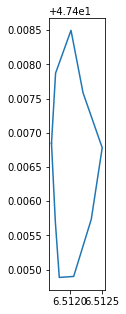

In [8]:
# plot shapely object
plt.figure(figsize=(1,5))
plt.plot(*footprint.exterior.xy)
plt.show()

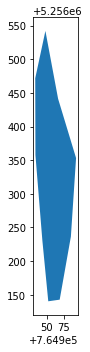

In [11]:
# plot geodataframe row
fig, ax = plt.subplots(figsize=(5,5))
forests[0:1].plot(ax=ax)
plt.tight_layout()
#plt.savefig('figure.png')
plt.show()

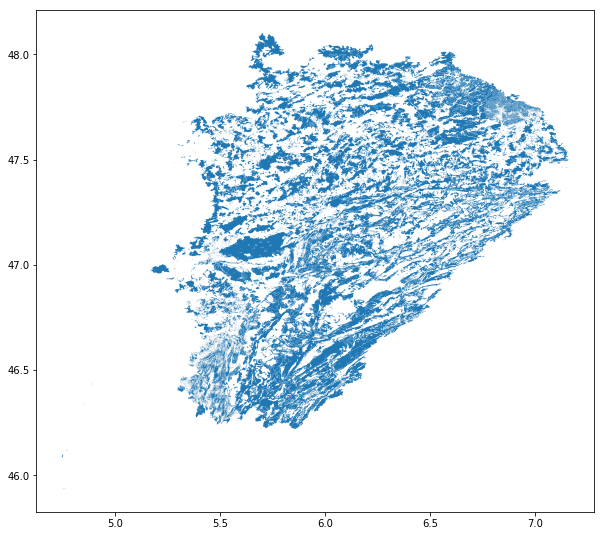

In [19]:
# plot all forest shapes at once
forests.plot(figsize=(10,10))
plt.show()

Now we can run a query on the api we have created above. There are different ways to construct a query depending on the use case, here we will create a query for Sentinel 2 images Level 2A with cloud coverage between 0 and 10 that fall or intersect with the footprint (area of study). For the time period, we are interested in Sentinel Level 2A satellite images taken between '20200320' and '20200405' (for reference on valid search queries please refer to [scihub](https://scihub.copernicus.eu/userguide/OpenSearchAPI)).

In [140]:
products = api.query(footprint,
                     date = ('20200404', '20200408'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0,10))

We get a dictionary of all products available in this period with the query specification. In this case, we receive only 6 images taken but you can tweak the query for your use case example expanding the time period or increasing the cloud coverage percentage.  


In [13]:
len(products)

4

From here we can create a GeodataFrame from the product dictionary and sort them according to cloud coverage percentage.

In [141]:
products_gdf = api.to_geodataframe(products)
products_gdf_sorted = products_gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
products_gdf_sorted

/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


title  \
d45ddf02-a027-4673-a4a2-5d27e64c7961  S2A_MSIL2A_20200407T104021_N0214_R008_T31TGN_2...   
c8fb2860-efe3-407a-abef-53a2aa5e536e  S2A_MSIL2A_20200407T104021_N0214_R008_T32TLT_2...   
85fa1176-363d-4d04-be07-d3a95e18a47d  S2A_MSIL2A_20200404T103021_N0214_R108_T31TGN_2...   
79044d19-d130-421d-a647-6d582a79df7e  S2A_MSIL2A_20200404T103021_N0214_R108_T32TLT_2...   

                                                                                   link  \
d45ddf02-a027-4673-a4a2-5d27e64c7961  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
c8fb2860-efe3-407a-abef-53a2aa5e536e  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
85fa1176-363d-4d04-be07-d3a95e18a47d  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
79044d19-d130-421d-a647-6d582a79df7e  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                       link_alternative  \
d45ddf02-a027-4673-a4a2-5d27e64c7961  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
c8fb2860-efe3-407a-abef-53a2aa5e536e  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
85fa1176-363d-4d04-be07-d3a95e18a47d  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
79044d19-d130-421d-a647-6d582a79df7e  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                              link_icon  \
d45ddf02-a027-4673-a4a2-5d27e64c7961  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
c8fb2860-efe3-407a-abef-53a2aa5e536e  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
85fa1176-363d-4d04-be07-d3a95e18a47d  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
79044d19-d130-421d-a647-6d582a79df7e  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                                summary  \
d45ddf02-a027-4673-a4a2-5d27e64c7961  Date: 2020-04-07T10:40:21.024Z, Instrument: MS...   
c8fb2860-efe3-407a-abef-53a2aa5e536e  Date: 2020-04-07T10:40:21.024Z, Instrument: MS...   
85fa1176-363d-4d04-be07-d3a95e18a47d  Date: 2020-04-04T10:30:21.024Z, Instrument: MS...   
79044d19-d130-421d-a647-6d582a79df7e  Date: 2020-04-04T10:30:21.024Z, Instrument: MS...   

                                               beginposition  \
d45ddf02-a027-4673-a4a2-5d27e64c7961 2020-04-07 10:40:21.024   
c8fb2860-efe3-407a-abef-53a2aa5e536e 2020-04-07 10:40:21.024   
85fa1176-363d-4d04-be07-d3a95e18a47d 2020-04-04 10:30:21.024   
79044d19-d130-421d-a647-6d582a79df7e 2020-04-04 10:30:21.024   

                                                 endposition  \
d45ddf02-a027-4673-a4a2-5d27e64c7961 2020-04-07 10:40:21.024   
c8fb2860-efe3-407a-abef-53a2aa5e536e 2020-04-07 10:40:21.024   
85fa1176-363d-4d04-be07-d3a95e18a47d 2020-04-04 10:30:21.024   
79044d19-d130-421d-a647-6d582a79df7e 2020-04-04 10:30:21.024   

                                               ingestiondate  orbitnumber  \
d45ddf02-a027-4673-a4a2-5d27e64c7961 2020-04-07 16:51:10.953        25030   
c8fb2860-efe3-407a-abef-53a2aa5e536e 2020-04-07 16:55:49.328        25030   
85fa1176-363d-4d04-be07-d3a95e18a47d 2020-04-04 20:57:52.913        24987   
79044d19-d130-421d-a647-6d582a79df7e 2020-04-04 20:38:57.417        24987   

                                      relativeorbitnumber  ...  \
d45ddf02-a027-4673-a4a2-5d27e64c7961                    8  ...   
c8fb2860-efe3-407a-abef-53a2aa5e536e                    8  ...   
85fa1176-363d-4d04-be07-d3a95e18a47d                  108  ...   
79044d19-d130-421d-a647-6d582a79df7e                  108  ...   

                                      processingbaseline  processinglevel  \
d45ddf02-a027-4673-a4a2-5d27e64c7961               02.14         Level-2A   
c8fb2860-efe3-407a-abef-53a2aa5e536e               02.14         Level-2A   
85fa1176-363d-4d04-be07-d3a95e18a47d               02.14         Level-2A   
79044d19-d130-421d-a647-6d582a79df7e               02.14         Level-2A   

                                      producttype  platfo

We could also create a geojson file with `api.to_geojson(products)`, or get each product's metadata with `api.get_product_odata('product_id')`.

Let's check on folium if the products match with our forest polygons (in the map, we can choose the layer we display):

In [15]:
m = folium.Map([47.4, 6.5], zoom_start=8)

folium.GeoJson(forests[0:500], name='forests').add_to(m)
folium.GeoJson(products_gdf_sorted['geometry'], name='satellite images',
               style_function=lambda x: {'color':'#228B22'}).add_to(m)
folium.LatLngPopup().add_to(m)
folium.LayerControl().add_to(m)
m

Let's say we are interested in the first satellite image since this has the least cloud coverage. We simply call `api.download(<image id>)` (and to download all images we could use `api.download_all()`). Beware, this could take a while, as Sentinel 2 satellite image tiles are about 1 GB.

In [20]:
api.download("c8fb2860-efe3-407a-abef-53a2aa5e536e")

Downloading: 100%|██████████| 532M/532M [07:18<00:00, 1.21MB/s] 
MD5 checksumming: 100%|██████████| 532M/532M [00:01<00:00, 284MB/s] 


{'id': 'c8fb2860-efe3-407a-abef-53a2aa5e536e',
 'title': 'S2A_MSIL2A_20200407T104021_N0214_R008_T32TLT_20200407T113125',
 'size': 531712414,
 'md5': 'F68B48BF40E279BBF339DF0BDFC43A9A',
 'date': datetime.datetime(2020, 4, 7, 10, 40, 21, 24000),
 'footprint': 'POLYGON((7.168489309055363 47.83679684435136,7.155148000321558 47.80718644444384,7.090105018842064 47.66223487327056,7.02519533892263 47.51726037424013,6.959664699551944 47.372436494868914,6.894373230169248 47.22744189759093,6.829938601253819 47.08228903361849,6.765324555159915 46.93729397086368,6.7251022156911 46.84142863874846,6.377280362167834 46.835643714163524,6.327926759464818 47.82259512731069,7.168489309055363 47.83679684435136))',
 'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('c8fb2860-efe3-407a-abef-53a2aa5e536e')/$value",
 'Online': True,
 'Creation Date': datetime.datetime(2020, 4, 7, 16, 56, 2, 363000),
 'Ingestion Date': datetime.datetime(2020, 4, 7, 16, 55, 49, 328000),
 'path': './S2A_MSIL2A_20200407T

Once the download is over, we can simply unzip it. In the next section, we will process, analyze and visualize the satellite image.

## Exploring data with `rasterio`

Once we unzip the downloaded folder, we get many subfolders. Sentinel-2 data is multispectral, with 13 bands in the visible, near infrared and shortwave infrared spectrum (RGB correspond to bands 4, 3 and 2 respectively). These bands come in a different spatial resolution ranging from 10 m to 60 m, thus images can be categorized as high-medium resolution. There are other higher resolution satellites available (1m to 0.5 cm),but Sentinel-2 data is free and has a high revisit time (5 days), which makes it an excellent option.

Let's create an RGB image with `rasterio` based on the available bands in the downloaded folder.

### Create RGB Image

First we open the 3 bands we need:

In [15]:
# Open Bands 4, 3 and 2 of resolution 10m with rasterio
R10 = '../Data/S2A_MSIL2A_20200407T104021_N0214_R008_T32TLT_20200407T113125.SAFE/GRANULE/L2A_T32TLT_A025030_20200407T104541/IMG_DATA/R10m'

b4 = rio.open(R10+'/T32TLT_20200407T104021_B04_10m.jp2', driver="JP2OpenJPEG") # driver is optional when we read
b3 = rio.open(R10+'/T32TLT_20200407T104021_B03_10m.jp2', driver="JP2OpenJPEG")
b2 = rio.open(R10+'/T32TLT_20200407T104021_B02_10m.jp2', driver="JP2OpenJPEG")

/opt/anaconda3/lib/python3.7/site-packages/rasterio/__init__.py:217: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)


We can get several infos about these bands:

In [16]:
b4.count, b4.width, b4.height

(1, 10980, 10980)

In [17]:
b4.colorinterp[0]

<ColorInterp.grey: 1>

In [18]:
# check metadata
b4.meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint16',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 1,
 'crs': CRS({'init': 'epsg:32632'}),
 'transform': Affine(10.0, 0.0, 300000.0,
        0.0, -10.0, 5300040.0)}

Matadata shows:  
* crs: `epsg:32631` is WSG84's crs id for the band covering the center of France, and `epsg:32632` is WSG84's crs id for the band covering the east of France
* dtype: for now format is `uint16`, we will convert it to `uint8` in order to manipulate the image more easily and to plot it once it's written to RGB.

We can also plot the bands:

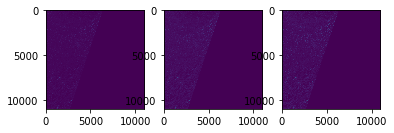

In [24]:
# plot bands with matplotlib
plt.subplot(131) # 1x3 grid, 1st subplot
plt.imshow(b2.read(1))
plt.subplot(132)
plt.imshow(b3.read(1))
plt.subplot(133)
plt.imshow(b4.read(1))
plt.show()

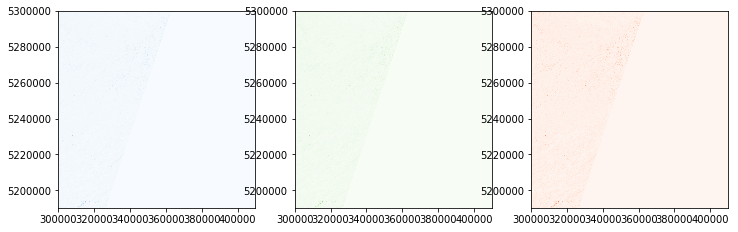

In [59]:
# plot bands with rasterio's plot.show method, in different color shades
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
show(b2, ax=ax1, cmap='Blues')
show(b3, ax=ax2, cmap='Greens')
show(b4, ax=ax3, cmap='Reds')
plt.show()

We can convert the bands to a different bit format (`uint8`):

In [27]:
b4_uint8 = b4.read(1).astype(rasterio.uint8) # we read and convert the first (and unique) band in the file
b3_uint8 = b3.read(1).astype(rasterio.uint8) # we read and convert the first (and unique) band in the file
b2_uint8 = b2.read(1).astype(rasterio.uint8) # we read and convert the first (and unique) band in the file

In [29]:
print(b4_uint8.dtype)
b4_uint8

uint8


array([[ 73, 245, 194, ...,   0,   0,   0],
       [ 71, 255, 208, ...,   0,   0,   0],
       [ 56, 235, 235, ...,   0,   0,   0],
       ...,
       [ 79, 138, 187, ...,   0,   0,   0],
       [ 19, 163, 183, ...,   0,   0,   0],
       [218, 158, 188, ...,   0,   0,   0]], dtype=uint8)

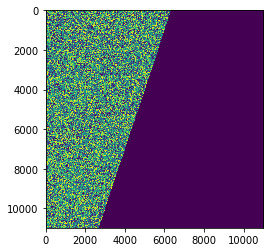

In [9]:
# plot band 4 with plt
plt.imshow(b4_uint8);

The plot looks weird but I guess it's the python interface, normally the conversion worked... Let's try with `float32`.

In [11]:
b4_float = b4.read(1).astype(rasterio.float32) # we read and convert the first (and unique) band in the file
b4_float.dtype

dtype('float32')

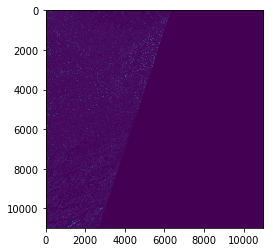

In [12]:
# plot band 4 with plt
plt.imshow(b4_float);

Dark output but the code should also be correct.

And now we finally write the RGB image:

In [ ]:
# write RGB tiff image
with rio.open('../Data/RGB3.tiff','w',driver='Gtiff', width=b4.width, height=b4.height, 
              count=3,crs=b4.crs,transform=b4.transform, dtype=b4.dtypes[0]) as rgb:
    rgb.write(b4.read(1),1) 
    rgb.write(b3.read(1),2) 
    rgb.write(b2.read(1),3) 
    rgb.close()

And we show it with rasterio's `show` method:

In [ ]:
src = rio.open('../Data/RGB3.tiff','r', count=3)
show(src);

In [ ]:
src.meta

The colors are weird but it is correct, this is only due to the python interface. In a specialized software we would see the true colors.

I tried to plot it also with matplotlib, but the problemis it's in `uint16` format, which isn't supported by matplotlib. In the next cells we will try to convert it to `uint8`or `float32`.

In [16]:
raster_img = src.read()
print(raster_img.shape)
print(raster_img.dtype)
raster_img

(3, 10980, 10980)
uint16


array([[[841, 757, 706, ...,   0,   0,   0],
        [839, 767, 720, ...,   0,   0,   0],
        [824, 747, 747, ...,   0,   0,   0],
        ...,
        [335, 138, 187, ...,   0,   0,   0],
        [275, 163, 183, ...,   0,   0,   0],
        [218, 158, 188, ...,   0,   0,   0]],

       [[623, 576, 539, ...,   0,   0,   0],
        [601, 557, 539, ...,   0,   0,   0],
        [569, 561, 539, ...,   0,   0,   0],
        ...,
        [304, 224, 224, ...,   0,   0,   0],
        [285, 245, 229, ...,   0,   0,   0],
        [233, 223, 238, ...,   0,   0,   0]],

       [[450, 413, 400, ...,   0,   0,   0],
        [427, 413, 391, ...,   0,   0,   0],
        [437, 419, 374, ...,   0,   0,   0],
        ...,
        [184, 102, 130, ...,   0,   0,   0],
        [171, 102, 133, ...,   0,   0,   0],
        [169,  71, 117, ...,   0,   0,   0]]], dtype=uint16)

In [17]:
raster_img = reshape_as_image(raster_img)
print(raster_img.shape)
print(raster_img.dtype)
raster_img

(10980, 10980, 3)
uint16


array([[[841, 623, 450],
        [757, 576, 413],
        [706, 539, 400],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[839, 601, 427],
        [767, 557, 413],
        [720, 539, 391],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[824, 569, 437],
        [747, 561, 419],
        [747, 539, 374],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[335, 304, 184],
        [138, 224, 102],
        [187, 224, 130],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[275, 285, 171],
        [163, 245, 102],
        [183, 229, 133],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[218, 233, 169],
        [158, 223,  71],
        [188, 238, 117],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [ ]:
# fails because of uint16
#plt.figure(figsize=(4,4))
#plt.imshow(raster_img)

I try to convert and plot with `opencv`:

In [4]:
uint8 = cv2.convertScaleAbs(src.read(), alpha=(255.0/2970.0))
print(uint8.shape)
print(uint8.dtype)
uint8

(1, 10980, 10980)
uint8


array([[[255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        ...,
        [255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0]]], dtype=uint8)

In [ ]:
# opencv fails on my kernel
cv2.imshow('image', uint8)

In [7]:
img_bgr = cv2.cvtColor(src.read(), cv2.COLOR_RGB2BGR)

In [ ]:
# opencv fails on my kernel
cv2.imshow('image', img_bgr)

In [ ]:
uint8 = reshape_as_image(uint8)
plt.figure(figsize=(4,4))
plt.imshow(uint8)

Let's try to convert the image to `uint8` with rasterio:

In [14]:
uint8 = src.read().astype(rasterio.uint8)
print(uint8.dtype)
print(uint8.shape)
uint8

uint8
(3, 10980, 10980)


array([[[ 73, 245, 194, ...,   0,   0,   0],
        [ 71, 255, 208, ...,   0,   0,   0],
        [ 56, 235, 235, ...,   0,   0,   0],
        ...,
        [ 79, 138, 187, ...,   0,   0,   0],
        [ 19, 163, 183, ...,   0,   0,   0],
        [218, 158, 188, ...,   0,   0,   0]],

       [[111,  64,  27, ...,   0,   0,   0],
        [ 89,  45,  27, ...,   0,   0,   0],
        [ 57,  49,  27, ...,   0,   0,   0],
        ...,
        [ 48, 224, 224, ...,   0,   0,   0],
        [ 29, 245, 229, ...,   0,   0,   0],
        [233, 223, 238, ...,   0,   0,   0]],

       [[194, 157, 144, ...,   0,   0,   0],
        [171, 157, 135, ...,   0,   0,   0],
        [181, 163, 118, ...,   0,   0,   0],
        ...,
        [184, 102, 130, ...,   0,   0,   0],
        [171, 102, 133, ...,   0,   0,   0],
        [169,  71, 117, ...,   0,   0,   0]]], dtype=uint8)

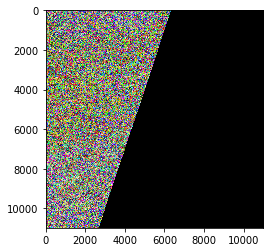

In [15]:
uint8 = reshape_as_image(uint8)
plt.imshow(uint8);

Same as in the previous section, weird output but the computation normally worked.

Convert using `skimage`:

In [31]:
# convert tif to np array in uint8 format
from skimage import img_as_ubyte
raster_img_ub = img_as_ubyte(raster_img)
raster_img_ub.shape

In [32]:
raster_img_ub = np.swapaxes(raster_img_ub, 0, 2)
print(raster_img_ub.shape)
raster_img_ub

(3, 10980, 10980)


array([[[3, 3, 3, ..., 1, 1, 0],
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 1, 1, 0],
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

All this works theoretically but values of pixels are too low, it looks like the exposure isn't correct from the start. Let's try to correct it.

In [21]:
from skimage import exposure, img_as_ubyte
img = img_as_ubyte(exposure.rescale_intensity(src.read()))
print(img.shape)
img

array([[[11, 10,  9, ...,  0,  0,  0],
        [11, 10,  9, ...,  0,  0,  0],
        [11, 10, 10, ...,  0,  0,  0],
        ...,
        [ 4,  1,  2, ...,  0,  0,  0],
        [ 3,  2,  2, ...,  0,  0,  0],
        [ 3,  2,  2, ...,  0,  0,  0]],

       [[ 8,  7,  7, ...,  0,  0,  0],
        [ 8,  7,  7, ...,  0,  0,  0],
        [ 7,  7,  7, ...,  0,  0,  0],
        ...,
        [ 4,  3,  3, ...,  0,  0,  0],
        [ 3,  3,  3, ...,  0,  0,  0],
        [ 3,  3,  3, ...,  0,  0,  0]],

       [[ 6,  5,  5, ...,  0,  0,  0],
        [ 5,  5,  5, ...,  0,  0,  0],
        [ 6,  5,  5, ...,  0,  0,  0],
        ...,
        [ 2,  1,  1, ...,  0,  0,  0],
        [ 2,  1,  1, ...,  0,  0,  0],
        [ 2,  0,  1, ...,  0,  0,  0]]], dtype=uint8)

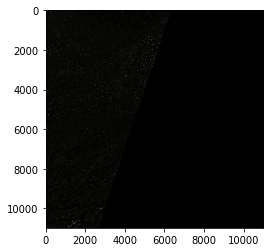

In [23]:
img=reshape_as_image(img)
plt.imshow(img)

Still too dark. There might be other issues.

### Mask Satellite images

Since this RGB image is super large, to save both computing power and time we will clip and use only our areas of interest.

In [62]:
# open original image and compute masking
with rio.open("../Data/RGB3.tiff") as src:
    out_image, out_transform = rio.mask.mask(src, forests['geometry'][797:798])
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

/opt/anaconda3/lib/python3.7/site-packages/rasterio/mask.py:89: UserWarning: shapes are outside bounds of raster. Are they in different coordinate reference systems?
  warnings.warn('shapes are outside bounds of raster. '


They tell me bounds of polygon do not intersect with raster, while they actually do... based on what we could see previously in folium :/

In [76]:
src = rio.open("../Data/RGB3.tiff", 'r')

failed = []
for num, row in forests.iterrows():
    try:
        masked_image, out_transform = rio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
    except Exception as e:
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))

Rasterio failed to mask 48398 files


Maybe it fails because of a coordinate system problem.

In [66]:
forests = forests.to_crs({'init' : src.meta['crs']['init']})

/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [67]:
failed = []
for num, row in forests.iterrows():
    try:
        masked_image, out_transform = rio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
    except Exception as e:
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))

Rasterio failed to mask 48398 files


Still the same problem, no shape intersects. Let's try to convert shapes not only to the image CRS, but also using the raster's `transform` attribute.

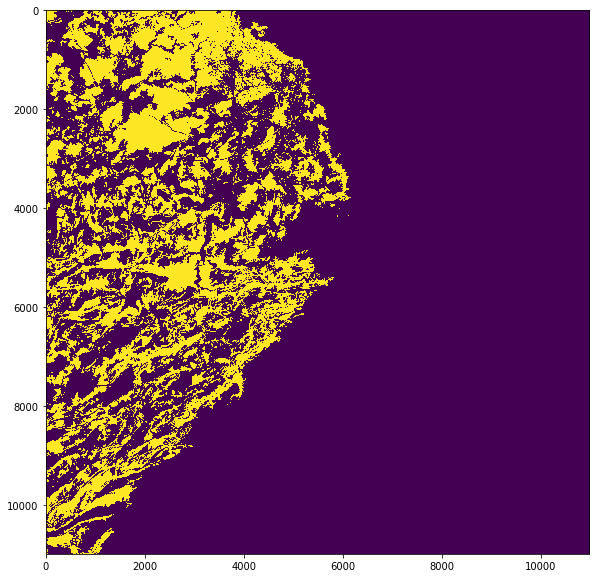

In [68]:
def poly_from_utm(polygon, transform):
    poly_pts = []
    
    # make a polygon from multipolygon
    poly = cascaded_union(polygon)
    for i in np.array(poly.exterior.coords):
        
        # transfrom polygon to image crs, using raster meta
        poly_pts.append(~transform * tuple(i))
        
    # make a shapely Polygon object
    new_poly = Polygon(poly_pts)
    return new_poly

# creating binary mask

poly_shp = []
im_size = (src.meta['height'], src.meta['width'])
for num, row in forests.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        poly = poly_from_utm(row['geometry'], src.meta['transform'])
        poly_shp.append(poly)
    else:
        for p in row['geometry']:
            poly = poly_from_utm(p, src.meta['transform'])
            poly_shp.append(poly)

mask = rasterize(shapes=poly_shp,
                 out_shape=im_size)

# plotting the mask

plt.figure(figsize=(10,10))
plt.imshow(mask);

It worked !! We've got the mask.

In [ ]:
# saving mask
bin_mask_meta = src.meta.copy()
bin_mask_meta.update({'count': 1})
with rasterio.open("train.jp2", 'w', **bin_mask_meta) as dst:
    dst.write(mask * 255, 1)

Now maybe we can retry the previous masking code with `poly_shp` instead of the whole `forests`geodataframe.

In [ ]:
failed = []
for polygon in poly_shp:
    try:
        masked_image, out_transform = rio.mask.mask(src, poly_shp[0:100], crop=True, nodata=0)
    except Exception as e:
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))

In [71]:
failed = []
for num, row in forests.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        row['geometry'] = poly_from_utm(row['geometry'], src.meta['transform'])
        try:
            masked_image, out_transform = rio.mask.mask(src, row['geometry'], crop=True, nodata=0)
        except Exception as e:
            failed.append(num)
    else: 
        try:
            masked_image, out_transform = rio.mask.mask(src, row['geometry'], crop=True, nodata=0)
        except Exception as e:
            failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))

Rasterio failed to mask 48398 files


Well it still doesn't seem to find intersections to mask.

Investigations below. Trying to replace the geometries in `forests` geodataframe with transformed geometries from `poly_shp`, which seem to match with the raster.

In [77]:
# original geometries
forests[0:1]['geometry']

2    POLYGON ((312272.214 5253378.917, 312280.712 5...
Name: geometry, dtype: geometry

In [75]:
# geometries that seem to match with raster
poly_shp[0:5]

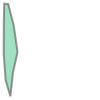

In [73]:
poly_shp[0]

In [97]:
print(poly_shp[0])

POLYGON ((1227.221410974002 4666.108317204053, 1228.071167787875 4654.724570259452, 1230.119107844024 4647.833174786181, 1231.221737802141 4658.029044573312, 1233.205001127768 4667.01942891418, 1231.538061633823 4678.597294221283, 1229.157440457959 4687.812967103906, 1227.447912360498 4687.922917712247, 1227.269275283779 4678.84675082902, 1227.221410974002 4666.108317204053))


These polygones above are the geometries we want in a new geodataframe.

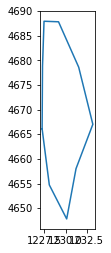

In [79]:
# plot shapely object
plt.figure(figsize=(1,4))
plt.plot(*poly_shp[0].exterior.xy)
plt.show()

In [130]:
# convert shapely objects in poly_shp to new forests geodataframe

# I tried to replace geometries ieratively, not working:
#forests_new = forests.copy()
#for num, row in forests_new.iterrows():
#    row = gpd.GeoDataFrame(index=[num], crs={'init': 'epsg:32632'}, geometry=[poly_shp[num]])
#    print(num)

# I tried with a lambda, not working:
#forests_new = forests_new.apply(replace_geom, axis=1)

# I tried by converting poly_shp to geoseries and then to a whole new geodataframe, it worked!
forests = forests.reset_index(drop=True)
forests_new = gpd.GeoDataFrame(gpd.GeoSeries(poly_shp), columns = ['geometry'], crs={'init':'epsg:32632'})
print(type(forests_new))
print(forests_new.crs)
forests_new.head(1)

<class 'geopandas.geodataframe.GeoDataFrame'>
+init=epsg:32632 +type=crs


geometry
0  POLYGON ((1227.221 4666.108, 1228.071 4654.725...

In [136]:
#new test
failed = []
for num, row in forests_new.iterrows():
    try:
        masked_image, out_transform = rio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
    except Exception as e:
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))

Rasterio failed to mask 48586 files


Well we managed to try the masking script with the correct geometries, which are supposed to match with the raster... but it still fails.

We could have finally written the masked image to disk:

In [ ]:
# write masked image
with rasterio.open("../Data/RGB_masked.tiff", "w", **src.meta) as dest:
    dest.write(masked_image)

In [ ]:
#open and show masked image with rasterio
msk = rio.open(r"RGB_masked.tif")
fig, ax = plt.subplots(1, figsize=(18, 18))
show(msk.read([1,2,3]))
plt.show()

### Create NDVI 
Calculating Normalized Difference Vegetation Index (NDVI) is an important indicator to assess the presence/absence of green vegetation from the satellite images. It is often used to monitor forests health. To calculate the NDVI, you need Red band and Near-Infrared Band (NIR). Different satellite images assign different numbers for this band. Sentinel Images have red in 4th band and NIR in the 8th band. The formula for NDVI calculation is:
nir - red /(nir + red).

To carry out this in Rasterio we need first to read the 4th and 8th bands as arrays. We also need to make sure that the arrays are floats.

In [64]:
b4 = rio.open(R10+'/T32TLT_20200407T104021_B04_10m.jp2')
b8 = rio.open(R10+'/T32TLT_20200407T104021_B08_10m.jp2')

In [65]:
red = b4.read()
nir = b8.read()

In [66]:
ndvi = (nir.astype(float)-red.astype(float))/(nir+red)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [67]:
meta = b4.meta

meta.update(driver='GTiff')
meta.update(dtype=rasterio.float32)

with rasterio.open('NDVI.tif', 'w', **meta) as dst:
    dst.write(ndvi.astype(rasterio.float32))

In [68]:
dst = rio.open('../Data/NDVI.tif')
dst = dst.read()
print(dst.shape)
dst

(1, 10980, 10980)


array([[[0.41819438, 0.44440368, 0.4347478 , ...,        nan,
                nan,        nan],
        [0.4191762 , 0.43290204, 0.41794664, ...,        nan,
                nan,        nan],
        [0.40634006, 0.42516354, 0.40359282, ...,        nan,
                nan,        nan],
        ...,
        [0.67865705, 0.80753136, 0.7777778 , ...,        nan,
                nan,        nan],
        [0.6946141 , 0.79586726, 0.807267  , ...,        nan,
                nan,        nan],
        [0.71240103, 0.81168056, 0.80355275, ...,        nan,
                nan,        nan]]], dtype=float32)

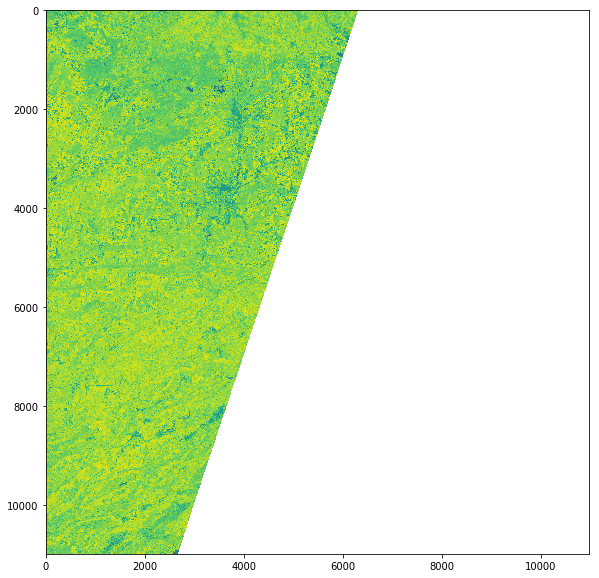

In [13]:
plt.figure(figsize=(10,10))
show(dst);

**NDVI could help for detection of tree diseases**! See more info here: https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index.

## Accessing data stored in AWS cloud

We can also access images in a cloud service such as AWS.

In [14]:
fpath = 'http://landsat-pds.s3.amazonaws.com/c1/L8/003/065/LC08_L1TP_003065_20190925_20191017_01_T1/LC08_L1TP_003065_20190925_20191017_01_T1_B4.TIF'
#this is band 4

def rasterio_open(f):
    return rio.open(f)

src_image = rasterio_open(fpath)
print(src_image.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7601, 'height': 7741, 'count': 1, 'crs': CRS({'init': 'epsg:32619'}), 'transform': Affine(30.0, 0.0, 363285.0,
       0.0, -30.0, -683685.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


In [21]:
overview = src_image.overviews(1)[-1]
overview

81

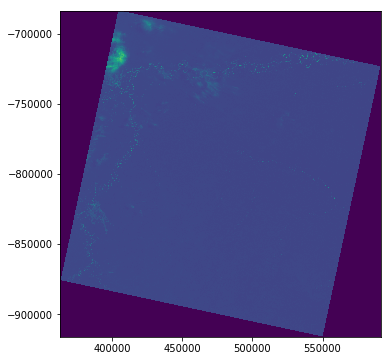

In [23]:
fig, ax = plt.subplots(1, figsize=(6, 6))
show(src_image, ax=ax)
plt.show()

In [24]:
src_image_array = src_image.read(1)
src_image_array = src_image_array.astype("f4")
src_image_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [25]:
src_image_array[src_image_array==0] = np.nan

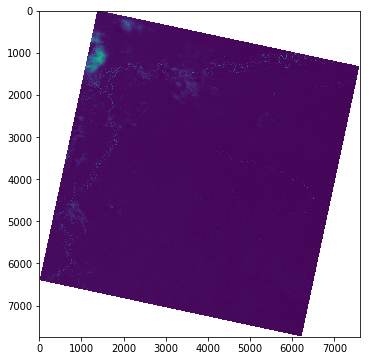

In [27]:
fig, ax = plt.subplots(1, figsize=(6, 6))
show(src_image_array, ax=ax)
plt.show()

In [30]:
print(src_image_array.dtype)
print(src_image_array.shape)

float32
(7741, 7601)


### Get subset of an image

Using `window(col_off, row_off, width, height)`:

In [32]:
window = rio.windows.Window(1200, 1200, 750, 850)

In [34]:
subset = src_image.read(1, window=window)
subset.shape

(850, 750)

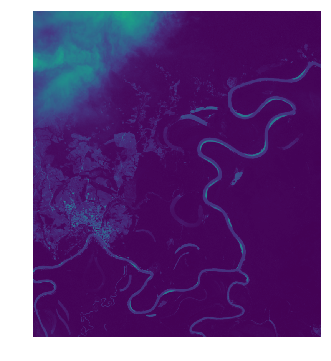

In [35]:
fig, ax = plt.subplots(1, figsize=(6, 6))
show(subset, ax=ax)
ax.set_axis_off()
plt.show()

### Create RGB image

In [36]:
rpath = 'http://landsat-pds.s3.amazonaws.com/c1/L8/003/065/LC08_L1TP_003065_20190925_20191017_01_T1/LC08_L1TP_003065_20190925_20191017_01_T1_B4.TIF'
gpath = 'http://landsat-pds.s3.amazonaws.com/c1/L8/003/065/LC08_L1TP_003065_20190925_20191017_01_T1/LC08_L1TP_003065_20190925_20191017_01_T1_B3.TIF'
bpath = 'http://landsat-pds.s3.amazonaws.com/c1/L8/003/065/LC08_L1TP_003065_20190925_20191017_01_T1/LC08_L1TP_003065_20190925_20191017_01_T1_B2.TIF'

In [37]:
red = rio.open(rpath)
green = rio.open(gpath)
blue = rio.open(bpath)

In [38]:
red_array = red.read(1)
green_array = green.read(1)
blue_array = blue.read(1)

In [39]:
print(red.profile)
print(red.width)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7601, 'height': 7741, 'count': 1, 'crs': CRS({'init': 'epsg:32619'}), 'transform': Affine(30.0, 0.0, 363285.0,
       0.0, -30.0, -683685.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
7601


In [41]:
# Create an RGB image 
with rio.open('../Data/RGB2.tiff','w',driver='Gtiff', width=red.width, height=red.height, 
              count=3,crs=red.crs,transform=red.transform, dtype=red.dtypes[0]) as rgb:
    rgb.write(blue.read(1),1) 
    rgb.write(green.read(1),2) 
    rgb.write(red.read(1),3) 
    rgb.close()

In [42]:
rgb = rio.open("../Data/RGB2.tiff")

In [45]:
rgb.profile

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7601, 'height': 7741, 'count': 3, 'crs': CRS({'init': 'epsg:32619'}), 'transform': Affine(30.0, 0.0, 363285.0,
       0.0, -30.0, -683685.0), 'tiled': False, 'interleave': 'pixel'}

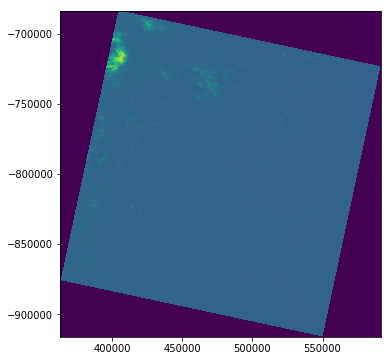

In [44]:
fig, ax = plt.subplots(1, figsize=(6, 6))
show(rgb, ax=ax)
plt.show()